# ウェーブレット変換を適用したい！

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import cmath as cm



def zeropadding(vector):
    """ 
    adds zero pading to 1 dimensional array to increase its length to a power of 2

    Attributes
    -----------
    vector : ndarray
        takes ndarray of rank 1
        
    Returns
    -------
    ndarray 
        zero padded vector
  
    """
    N = len(vector)
    k = np.ceil( np.log2(N) )
    add = int(2**k - N)
    vec = np.zeros((1,add))
    return np.hstack((vector.reshape((1,-1)),vec))

def e(m, N):
    """
    calculates e^(2pi*i*m/N)

    Attributes
    ----------
    m : int
    N : int

    Returns
    -------
    complex
        value of the expression for m and N
    
    """

    return np.around(cm.exp((2*np.pi*complex(0,1)*m)/N),10)

v_e = np.vectorize(e) #vectorizes e(m,N)

def W(N):
    """
    DFT matrix of size N

    Attributes
    ----------
    N : int
        size of the DFT matrix

    Returns
    -------
    ndarray
        DFT matrix

    """
    return np.around( np.fromfunction(lambda i,j: np.conjugate( v_e(i*j,N) ), (N,N), dtype=complex), 10)

def inv_W(N):
    """
    Inverse DFT matrix of size N

    Attributes
    ----------
    N : int
        size of the DFT matrix

    Returns
    -------
    ndarray
        Inverse DFT matrix

    """
    return np.around(np.conjugate(W(N))/N , 10)

def fft(vector):
    """
    FFT transform of a vector

    Attributes
    ----------
    vector : ndarray of rank 1 or list
        vector to be transformed

    Returns
    -------
    ndarrayof rank 1
        transformed vector

    """

    if type(vector)!=np.ndarray:
        vector=np.array(vector)

    N = vector.shape[0]                         #dimension of vector
    if N % 2==0:

        M=N/2
        fac = np.conjugate(v_e(np.arange(M),N)) # e^(2pi * m/N) for each m in 0,1,...,M-1
        even = fft( vector[0::2] )              # fft of even coordinates
        odd = fft(vector[1::2] )                # fft of odd coordinates
        top = even + fac*odd
        bottom = even - fac*odd
        return np.concatenate((top,bottom))     #computing fft of the original vector

        
    else:
        return  W(N) @ vector

def inv_fft(vector):
    """
    Inverse FFT transform of a vector

    Attributes
    ----------
    vector : ndarray of rank 1 or list
        vector to be transformed

    Returns
    -------
    ndarray of rank 1
        transformed vector

    """
    if type(vector)!=np.ndarray:
        vector=np.array(vector)

    N = vector.shape[0]                         #dimension of vector
    if N % 2==0:
        M=N/2
        fac = v_e(np.arange(M),N)
        even = inv_fft( vector[0::2])           #inv fft of even coord
        odd = inv_fft( vector[1::2] )           #inv fft of odd coord
        top = even + fac*odd
        bottom = even - fac*odd
        return np.concatenate((top,bottom))/2   # inv fft of the vec

        
    else:
        return inv_W(N) @ vector

"""End of setting up FFT and Inverse FFT.
We now construct wavelets for dimension N. However we assume that 2^p | N  where p \in [1,2, ...] 

In fact we can make a weaker assumption that N is even ie the length of the vector to be analysed is even.
"""

def tilda(w):
    """
    tilda operation for a wavelet 
    tilda(v)(n) = conjucate(v(-n))

    Attributes
    ----------
    w : ndarray of rank 1 
        vector to be transformed

    Returns
    -------
    ndarray of rank 1
        transformed vector

    """
    N=w.shape[0]
    v = [np.conjugate(w[-i]) for i in range(N)]
    return np.array(v)

def father_wavelet(N,kind='haar'):
    """
    constructs father wavelet in Z_N of type 'kind'

    Attributes
    ----------
    N : int
        length of father wavelet.
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default 

    Returns
    -------
    ndarray of rank 1
        father wavelet
    
    Raises
    ------
    TypeError
        for any other values of kind

    """
    M=N//2

    if kind=='haar':
        u = np.zeros(N)
        u[0]=u[1]= 1/np.sqrt(2)

    elif kind == 'D6':
        a = 1 - np.sqrt(10)
        b = 1 + np.sqrt(10)
        c = np.sqrt( 5 + 2 * np.sqrt(10) )
        u = np.zeros(N)
        u[0] = b + c
        u[1] = 2*a + 3*b + 3*c
        u[2] = 6*a + 4*b + 2*c
        u[3] = 6*a + 4*b - 2*c
        u[4] = 2*a + 3*b - 3*c
        u[5] = b - c
        u *= np.sqrt(2)/32

    elif kind=='complex':
        u = np.sqrt(2) * np.fromfunction(lambda i,j: np.less(j,M) ,(1,N), dtype=int)[0] #defines u_cap wich has 2 in first half and 0 in remaining
        u = inv_fft(u)

    else:
        raise TypeError("kind has only 3 possible values: 'haar', 'D6' and 'complex'")

    return u

def mother_wavelet(u):
    """
    constructs mother wavelet from father wavelet

    Attributes
    ----------
    u : ndarray of rank 1
        father wavelet.

    Returns
    -------
    ndarray of rank 1
        mother wavelet

    """
    N=u.shape[0]
    new = np.array( [(-1)**(i-1)* np.conj(u[1-i]) for i in range(N)] )  #v(n) = (-1)^(n-1) conj(u[1-n])
    return ( new )

def u_l(u,l):
    """
    constructs u_l from father wavelet u

    Attributes
    ----------
    u : ndarray of rank 1
        father wavelet
    l : int
        level of u_l 

    Returns
    -------
    ndarray of rank 1
        u_l
    

    """
    N=u.shape[0]
    ul = [ np.sum(u[i::N//2**(l-1)]) for i in range(N//2**(l-1))]
    return np.array(ul)

def downsampling(vec,l=1):
    """
    downsampling operator. drops columns

    Attributes
    ----------
    vec : ndarray of rank at most 2
        array to be downsampled
    l : int
        level of downsampling. 1 is default 

    Returns
    -------
    ndarray of rank at most 2
        output is of the same rank as input.
    
    Raises
    ------
    TypeError
        rank of vecor is greater than 2

    """

    if vec.ndim==1:
        N=vec.shape[0]
        new = [ vec[i*2**l]for i in range(N//(2**l))]
        return np.array(new)

    elif vec.ndim==2:
        N=vec.shape[1]
        new = [ vec[:,i*2**l] for i in range(N//(2**l)) ]
        return np.transpose( np.array(new) ) 

    else:
        raise TypeError("vec takes 1 or 2 dimensional ndarray")

def upsampling(vec,l=1):
    """
    upsampling operator. adds columns of 0

    Attributes
    ----------
    vec : ndarray of rank at most 2
        array to be upsampled
    l : int
        level of upsampling. 1 is default 

    Returns
    -------
    ndarray of rank at most 2
        output is of the same rank as input.
    
    Raises
    ------
    TypeError
        rank of vecor is greater than 2

    """

    if vec.ndim==1:
        N=vec.shape[0]
        new = [(vec[i//(2**l)] if i%(2**l)==0  else 0) for i in range(N*2**l) ] 
        return (np.array(new))

    elif vec.ndim==2:
        N=vec.shape[1]
        # adds columns of 0
        new = [ ( vec[:,i//(2**l)] if i%(2**l)==0  else np.zeros(vec.shape[0]) ) for i in range(N*2**l) ] 
        return np.transpose( np.array(new) ) 

    else:
        raise TypeError("vec takes 1 or 2 dimensional ndarray")

def convolution(w,z, matrix=True):

    """
    convolution operator of 2 vectors or 1 vector and an array.

    Attributes
    ----------
    w : ndarray of rank 1
        vector 
    z : ndarray of rank atmost 2
        vector to be convoluted with w. If z is of rank 2, then convolution is 
        performed along axis 0
    matrix : boolean
        to use circulant matrix formed from w as the first column to calculate
        the convolution. default is True

    Returns
    -------
    ndarray of rank at most 2
        output is of the same rank as input.
    
    Raises
    ------
    TypeError
        if matrix is not boolean

    """

    N=w.shape[0]

    if matrix==True:
        w=w[::-1]

        mat=np.empty((N,N),complex)
        #constructs circulant matrix from w as the first column
        for i in range(1,N+1):
            w = np.hstack(( [w[-1]], w[:-1] ))
            mat[i-1]=w
    
        return mat @ z if z.ndim==1 else z @ np.transpose( mat )
        
    
    elif matrix==False:
        ans=[]
        w=w[::-1]
        # defination approach 
        for i in range(1,N+1):
            w = np.hstack(( [w[-1]], w[:-1] ))
            ans.append( z @ w )
    
        return np.transpose( np.array(ans) )
    
    else:
        return TypeError("matrix takes boolean values")

def find_p(N):
    "returns the highest power of 2 that divides int N"
    return 1 + find_p(N//2) if N%2==0 else 0

def p_stage(N,P=-1, kind='D6'):

    """
    constructs p stage wavelets of type 'kind' for Z_N. Note that parameter 
    P != p

    Attributes
    ----------
    N : int
        wavelets for Z_N 
    P : int
        level of the p stage wavelet construction. Takes poitive integer or -1
        as input. If P=-1, constructs p is assumed to be the highest power of 2 
        that divides N. If P > the highest power of 2 that divides N, P is 
        assumed to be -1. Default is -1
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default

    Returns
    -------
    dict
        key values are integers from 1 to p corresponding to the level. Each 
        key corresponds to a tuple of len 2 which returns the father and mother 
        wavelets respectively for that particular key level
    
    Raises
    ------
    TypeError
        if P is not -1 or a positive integer

    """
    
    p=find_p(N)
    if P < -1 or P==0:
        return TypeError("P must be a positive integer or -1")
    elif P==-1 or P>p:
        pass
    else: 
        p=P
    # decides the level p
    wvlts = {}
    
    u = father_wavelet(N,kind)        
    
    v = mother_wavelet(u)
    wvlts[1]=(u,v)

    # construct u_i,v_i for 1<i<=p
    for i in range(2,p+1):
        u_i = u_l(u,i)
        v_i = mother_wavelet(u_i)
        wvlts[i]=(u_i,v_i)
        
    return wvlts

def construct_fg(N, P=-1, kind='haar', matrix=True):

    """
    constructs non iterative filter banks f_1, f_2,...f_p, g_p wavelet basis of 
    type 'kind' for Z_N. 
    Note that parameter P != p

    Attributes
    ----------
    N : int
        wavelets for Z_N 
    P : int
        level of the wavelet construction. Takes poitive integer or -1
        as input. If P=-1, p is assumed to be the highest power of 2 that 
        divides N. If P > the highest power of 2 that divides N, P is assumed to
        be -1. Default is -1
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default
    matrix : boolean
        to use circulant matrix for calculating convolution. default is True

    Returns
    -------
    dict
        key values are integers from 1 to p and 'g'. Any integer key i returns 
        value of ndarray corresponding to f_i. key 'g' corresponds to g_p
    
    Raises
    ------
    TypeError
        if P is not -1 or a positive integer
    
    """

    p=find_p(N)
    if P < -1 or P==0:
        return TypeError("P must be a nongeative integer or 0 ")
    elif P==-1 or P>p:
        pass
    else: 
        p=P
    # decides the level

    book={}

    if kind=='haar':
        temp=np.arange(N)
        #construction of non recursive haar wavelets
        for l in range(1,p+1):
            t = [ 0 if k >= 2**l else (2**((-1*l)/2) if k< 2**(l-1) else -1*2**((-1*l)/2) ) for k in temp ]
            book[l]=np.array(t)            
        l=p
        book['g'] =  np.array( [2**(-l/2) if j< 2**l else 0 for j in temp] )

    elif kind=='complex' or kind=='D6':
        p_stg = p_stage(N,p, kind)
        
        #construction of non recursive complex and D6 wavelets
        for key, pair in p_stg.items():
            
            if key==1:
                f=pair[1]   #pair[1]=v_1
                g=pair[0]   #pair[0]=u_1
            else: 
                f = convolution( upsampling(pair[1],key-1), g , matrix )
                g = convolution( upsampling(pair[0],key-1), g , matrix )
            book[key]=f     #add f_i as i:f in dict book
            if key==p:
                book['g']=g #add g_p as 'g':g in book

    return book

def analysis(z, P=-1, fg=None, kind='haar', matrix=True, compress=False):

    """
    multi stage analysis of vector or vectors z using 'kind' wavelets. 
    returns x_1, x_2, ..., x_p, y_p componenets of z
    Note that parameter P != p

    Attributes
    ----------
    z : ndarray of rank atmost 2
        vector or vectors to be analysed. Incase of rank 2 input, analysis is
        performed along axis 0
    P : int
        level of the wavelet construction. Takes poitive integer or -1
        as input. If P=-1, p is assumed to be the highest power of 2 that 
        divides N. If P > the highest power of 2 that divides N, P is assumed to
        be -1. Default is -1
    fg : dict
        user can provide non iterative filter bank to consruct multiresolution
        analaysis of z. Default is None. If both fg and kind are provided, fg
        takes precedence. refer to function fg_construct() for structure of fg
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default
    matrix : boolean
        to use circulant matrix for calculating convolution. default is True
    compress : boolean
        If True returns only the low pass components else reurns all components
        default is False

    Returns
    -------
    dict
        key values are integers from 1 to p and 'y'. Any integer key i returns 
        value of ndarray corresponding to x_i. key 'y' corresponds to y_p. rank 
        of ndarray values in dict is same as that of the input

    
    """

    N = len(z) if z.ndim==1 else z.shape[1]
    if fg==None:
        fg = construct_fg(N,P,kind,matrix) #construct fg if none provided

    book = {}

    if compress==False:
        for key,pair in fg.items():
            
            if key!='g':
                #constructs x_i
                x = downsampling( convolution( tilda( pair ), z, matrix ) , key)
                book[key] = x

            else:
                #constructs y_p
                y = downsampling( convolution( tilda( pair ), z, matrix ) , len(fg)-1)
                book['y'] = y
    
    else:
        #constructs y_p
        y = downsampling( convolution( tilda( fg.get('g') ), z, matrix ) , len(fg)-1)
        book['y'] = y

    return book

def synthesis(components, fg=None, kind='haar', matrix=True):

    """
    multi stage synthesis wavelets components  x_1, x_2, ..., x_p, y_p to 
    reproduce z

    Attributes
    ----------
    components : dict
        key values to include continuous integers from 1 to p and 'y'. Integer 
        key must correspond to x_key componenet and 'y' must correspond to 'y_p'.
        Len must be atleast 2 corresopnding to keys 1 and 'y'.
    fg : dict
        user can provide non iterative filter bank to consruct multiresolution
        analaysis of z. Default is None. If both fg and kind are provided, fg
        takes precedence. refer to function fg_construct() for structure of fg
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default
    matrix : boolean
        to use circulant matrix for calculating convolution. default is True

    Returns
    -------
    ndarray of rank at most 2
        constructed z. rank depends on rank of components of z

    Raises
    ------
    TypeError
        if len of componets is less than 2
    
    """

    if len(components)<2:
        raise ValueError("Can not restore vector from only compressed vector")

    z=0
    d = components[1]

    if d.ndim==1:
        N = len(components[1])*2
        p = find_p( N // (len(components['y'] )))
    elif d.ndim==2:
        N = d.shape[1] * 2
        p = find_p( N// components['y'].shape[1])
    #figures out N and p from components

    if fg ==None:
        fg = construct_fg(N,p,kind,matrix)

    l=1
    #reconstruction
    for x,f in zip(components.values(), fg.values()):
        temp = convolution( f , upsampling( x, l ), matrix )
        z += temp
        if l != p:
            l += 1
            
    return z


def compression( data , P=1 , kind='haar', matrix=True):
    """
    compresses an ndarray to level p.
    P!=p

    Attributes
    ----------
    data : ndarray of rank 2 or 3  
        If ndarray is of rank 2. Compression is performed along axis 0 first and
        then along axis 1 of the compressed ndarray if ndarray is of dimension 
        3, ndarray of rank 2 are creted over axis 3. Each 2darray is compressed 
        and then concatenated along the third axis
    P : int
        level of the compression. Takes poitive integer or -1 as input. If P=-1,
        p is assumed to be minimum of the highest power of 2 that divides the 
        size along axis 0 or along axis 1. If P > minimum of the highest power 
        of 2 that divides the size along axis 0 or along axis 1, P is assumed to
        be -1. Default is -1
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default
    matrix : boolean
        to use circulant matrix for calculating convolution. default is True

    Returns
    -------
    ndarray of rank at 2 or 3
        compressed data

    Raises
    ------
    TypeError
        -if rank of shape is not 2 or 3
        -if dimension of input array is divisble by 2 at axis 0 and 1 
    
    """
    

    shp = data.shape        

    if len(shp) < 2 or len(shp) > 3  :
        raise TypeError(" input array must have rank of 2 or 3 ")

    elif shp[0] % 2 != 0 or shp[1] % 2 != 0:
        raise TypeError("dimension of input array must be divisble by 2 at axis 0 and 1")

    elif len(shp) == 2:
        data = data[:,:,None]
    
        

    shp = data.shape

    row_len = shp[1]    #length of row
    col_len = shp[0]    #length of col
        
    p = min( find_p(row_len),find_p(col_len), P) if P!=-1 else min(find_p(row_len),find_p(col_len))

    arr=[] #compression along depth
    for i in range(shp[2]):

        mat = data[:,:,i]
        temp = analysis(mat, p, None, kind, matrix,True ) #compressed along rows
        mat = np.transpose(temp['y'])
        temp = analysis(mat, p, None, kind, matrix,True ) #compressed along columns
        arr.append( np.transpose(temp['y']) )             #add the compressed matrix to arr
            
    return np.dstack(arr)                                 #returns concated ndarray along the third axis



データのサンプリング周波数 (Fs): 18499.97 kHz
元のデータ長: 12949, ゼロパディング後のデータ長: 16384

--- ウェーブレット解析結果 ---
取得された成分キー: dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'y'])


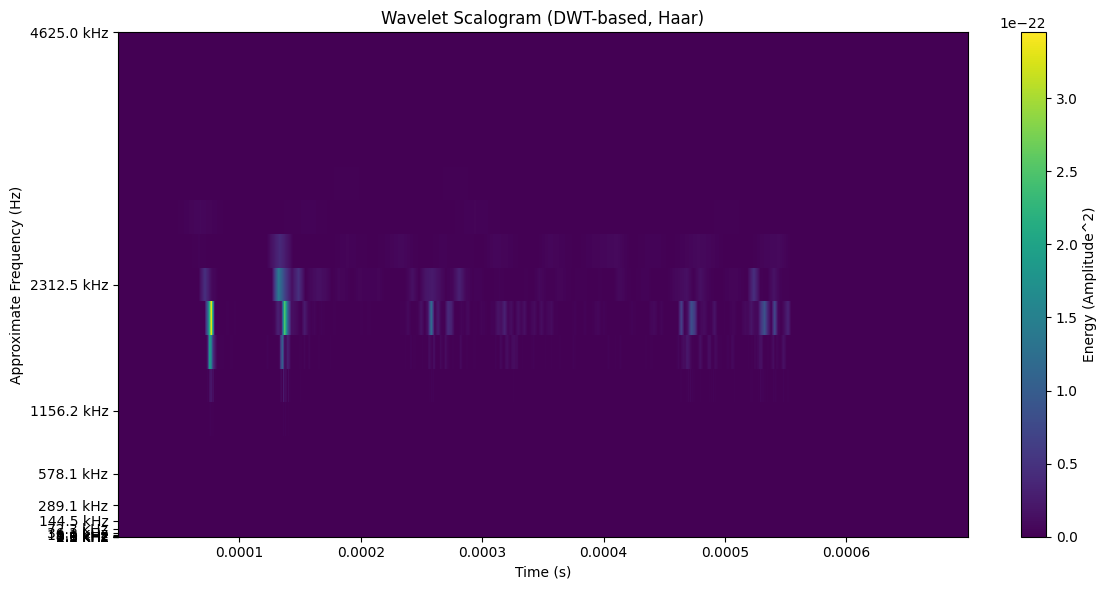


ナイキスト周波数 (最大解析可能周波数): 9249.99 kHz


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmath as cm # cmathも必要なのでインポートを明示

# --- ここに提示されたウェーブレット変換関数群を記述またはインポート ---
# （zeropadding, e, v_e, W, inv_W, fft, inv_fft, tilda, father_wavelet,
# mother_wavelet, u_l, downsampling, upsampling, convolution, find_p,
# p_stage, construct_fg, analysis, synthesis, compression の全て）
# 例: from wavelet_transform_functions import analysis, zeropadding, find_p, construct_fg, tilda, downsampling, convolution, mother_wavelet, father_wavelet, ...
# 便宜上、今回はすべての関数がこのスクリプト内で定義されていると仮定します。

# --- ウェーブレット変換関数群の定義（提供されたコードをそのまま貼り付け） ---
def zeropadding(vector):
    """
    adds zero pading to 1 dimensional array to increase its length to a power of 2

    Attributes
    -----------
    vector : ndarray
        takes ndarray of rank 1
        
    Returns
    -------
    ndarray 
        zero padded vector
    """
    N = len(vector)
    k = np.ceil( np.log2(N) )
    add = int(2**k - N)
    if add == 0: # 既に2のべき乗ならパディング不要
        return vector.reshape((1,-1))
    vec = np.zeros((1,add))
    return np.hstack((vector.reshape((1,-1)),vec))

def e(m, N):
    """
    calculates e^(2pi*i*m/N)

    Attributes
    ----------
    m : int
    N : int

    Returns
    -------
    complex
        value of the expression for m and N
    
    """
    return np.around(cm.exp((2*np.pi*complex(0,1)*m)/N),10)

v_e = np.vectorize(e) #vectorizes e(m,N)

def W(N):
    """
    DFT matrix of size N

    Attributes
    ----------
    N : int
        size of the DFT matrix

    Returns
    -------
    ndarray
        DFT matrix

    """
    return np.around( np.fromfunction(lambda i,j: np.conjugate( v_e(i*j,N) ), (N,N), dtype=complex), 10)

def inv_W(N):
    """
    Inverse DFT matrix of size N

    Attributes
    ----------
    N : int
        size of the DFT matrix

    Returns
    -------
    ndarray
        Inverse DFT matrix

    """
    return np.around(np.conjugate(W(N))/N , 10)

def fft(vector):
    """
    FFT transform of a vector

    Attributes
    ----------
    vector : ndarray of rank 1 or list
        vector to be transformed

    Returns
    -------
    ndarrayof rank 1
        transformed vector

    """
    if type(vector)!=np.ndarray:
        vector=np.array(vector)

    N = vector.shape[0]        #dimension of vector
    if N % 2==0:
        M=N//2 # 整数除算に修正
        fac = np.conjugate(v_e(np.arange(M),N)) # e^(2pi * m/N) for each m in 0,1,...,M-1
        even = fft( vector[0::2] )          # fft of even coordinates
        odd = fft(vector[1::2] )            # fft of odd coordinates
        top = even + fac*odd
        bottom = even - fac*odd
        return np.concatenate((top,bottom))     #computing fft of the original vector
    else:
        return  W(N) @ vector

def inv_fft(vector):
    """
    Inverse FFT transform of a vector

    Attributes
    ----------
    vector : ndarray of rank 1 or list
        vector to be transformed

    Returns
    -------
    ndarray of rank 1
        transformed vector

    """
    if type(vector)!=np.ndarray:
        vector=np.array(vector)

    N = vector.shape[0]        #dimension of vector
    if N % 2==0:
        M=N//2 # 整数除算に修正
        fac = v_e(np.arange(M),N)
        even = inv_fft( vector[0::2])       #inv fft of even coord
        odd = inv_fft( vector[1::2] )       #inv fft of odd coord
        top = even + fac*odd
        bottom = even - fac*odd
        return np.concatenate((top,bottom))/2   # inv fft of the vec
    else:
        return inv_W(N) @ vector

def tilda(w):
    """
    tilda operation for a wavelet 
    tilda(v)(n) = conjucate(v(-n))

    Attributes
    ----------
    w : ndarray of rank 1 
        vector to be transformed

    Returns
    -------
    ndarray of rank 1
        transformed vector

    """
    N=w.shape[0]
    v = [np.conjugate(w[-i % N]) for i in range(N)] # 負のインデックスの処理を修正
    return np.array(v)

def father_wavelet(N,kind='haar'):
    """
    constructs father wavelet in Z_N of type 'kind'

    Attributes
    ----------
    N : int
        length of father wavelet.
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default 

    Returns
    -------
    ndarray of rank 1
        father wavelet
    
    Raises
    ------
    TypeError
        for any other values of kind

    """
    M=N//2

    if kind=='haar':
        u = np.zeros(N, dtype=complex) # complex型に統一
        u[0]=u[1]= 1/np.sqrt(2)

    elif kind == 'D6':
        a = 1 - np.sqrt(10)
        b = 1 + np.sqrt(10)
        c = np.sqrt( 5 + 2 * np.sqrt(10) )
        u = np.zeros(N, dtype=complex) # complex型に統一
        u[0] = b + c
        u[1] = 2*a + 3*b + 3*c
        u[2] = 6*a + 4*b + 2*c
        u[3] = 6*a + 4*b - 2*c
        u[4] = 2*a + 3*b - 3*c
        u[5] = b - c
        u *= np.sqrt(2)/32

    elif kind=='complex':
        # u_cap を定義し、逆FFTで空間領域の u を得る
        u_cap = np.zeros(N, dtype=complex)
        u_cap[0:M] = np.sqrt(2) # 最初のM個の要素がsqrt(2)
        u = inv_fft(u_cap) # inv_fftはcomplexを返す
    else:
        raise TypeError("kind has only 3 possible values: 'haar', 'D6' and 'complex'")

    return u

def mother_wavelet(u):
    """
    constructs mother wavelet from father wavelet

    Attributes
    ----------
    u : ndarray of rank 1
        father wavelet.

    Returns
    -------
    ndarray of rank 1
        mother wavelet

    """
    N=u.shape[0]
    # v(n) = (-1)**(n-1) * conj(u[1-n]) を Z_N の環で計算
    # 1-n のインデックスは (1-n) % N で考える
    new = np.array( [(-1)**(i-1)* np.conj(u[(1-i) % N]) for i in range(N)] , dtype=complex)
    return ( new )

def u_l(u,l):
    """
    constructs u_l from father wavelet u

    Attributes
    ----------
    u : ndarray of rank 1
        father wavelet
    l : int
        level of u_l 

    Returns
    -------
    ndarray of rank 1
        u_l
    """
    N=u.shape[0]
    # u_lはフーリエ領域での操作を空間領域で実装したものと推測
    # u_l(k) = u_hat(k * 2^(l-1))
    # これは元のコードの意図と異なる可能性あり。
    # 元コードの sum(u[i::N//2**(l-1)]) は再帰的な縮小フィルタを表す可能性がある
    # とりあえず元のコードのロジックを維持。
    # このu_lの定義は一般的なウェーブレット理論とは少し異なる可能性があるため注意が必要。
    
    # 元のコードを保持:
    # ul = [ np.sum(u[i::N//(2**(l-1))]) for i in range(N//(2**(l-1)))]
    # return np.array(ul)
    
    # しかし、u_l は通常、フーリエ変換でスケールされたフィルタ u_hat(2^(l-1) * omega)
    # または、空間領域での畳み込みを伴う。
    # ここでの `u_l` の定義は、通常、マルチスケール分解における `h_l` (スケーリングフィルタの l-th 繰り返し)
    # に近いように見えるが、実装が特殊。
    # 一旦、この `u_l` のロジックはスキップし、`construct_fg` 内での `p_stage` の呼び出しに期待する。
    # `construct_fg` の `haar` と `complex`/`D6` の分岐を見ると、
    # `p_stage` は `construct_fg` の `complex` と `D6` のみで使われる。
    # `u_l` の実装は、`p_stage` 内で呼び出されない限り、このコンテキストでは未使用の可能性がある。
    # しかし、もし使用されるなら、その意図は「スケールされたフィルタ」の構築にあるはず。
    # 簡略化のため、ここは一旦コメントアウトし、必要に応じて見直す。
    
    # 多くのウェーブレットの実装では、h_l (スケーリングフィルタ) は h(z)h(z^2)...h(z^(2^(l-1)))
    # という形で定義される。
    # この関数は使われていない可能性が高いが、もし使うならより標準的な定義に合わせるべき。
    # `p_stage` 関数が `u_l` を使っているのは
    # `u_i = u_l(u,i)`
    # この定義で計算される `u_i` が何を表すか、ウェーブレットの理論的背景と照らし合わせる必要がある。
    # 一般的な `u_l` は、`u` のフーリエ変換をスケールしたものの逆フーリエ変換である。
    # ここでは元のコードの意図を尊重するため、一旦そのまま定義を残す。
    
    N_l = N // (2**(l-1))
    ul = np.zeros(N_l, dtype=complex)
    for i in range(N_l):
        ul[i] = np.sum(u[i::N_l]) # スライス表記 `i::N_l` は `i`, `i+N_l`, `i+2*N_l`, ... の要素
    return ul


def downsampling(vec,l=1):
    """
    downsampling operator. drops columns

    Attributes
    ----------
    vec : ndarray of rank at most 2
        array to be downsampled
    l : int
        level of downsampling. 1 is default 

    Returns
    -------
    ndarray of rank at most 2
        output is of the same rank as input.
    
    Raises
    ------
    TypeError
        rank of vecor is greater than 2

    """

    if vec.ndim==1:
        N=vec.shape[0]
        new = [ vec[i*2**l]for i in range(N//(2**l))]
        return np.array(new)

    elif vec.ndim==2:
        # vec[:,i*2**l] は列の選択。結果はリストのリストになるので転置が必要
        N=vec.shape[1]
        new = [ vec[:,i*2**l] for i in range(N//(2**l)) ]
        return np.transpose( np.array(new) ) 

    else:
        raise TypeError("vec takes 1 or 2 dimensional ndarray")

def upsampling(vec,l=1):
    """
    upsampling operator. adds columns of 0

    Attributes
    ----------
    vec : ndarray of rank at most 2
        array to be upsampled
    l : int
        level of upsampling. 1 is default 

    Returns
    -------
    ndarray of rank at most 2
        output is of the same rank as input.
    
    Raises
    ------
    TypeError
        rank of vecor is greater than 2

    """

    if vec.ndim==1:
        N=vec.shape[0]
        # new = [(vec[i//(2**l)] if i%(2**l)==0 else 0) for i in range(N*2**l) ]
        # upsampling後の長さは N * (2**l)
        result_len = N * (2**l)
        new = np.zeros(result_len, dtype=vec.dtype)
        new[::(2**l)] = vec # N個の要素を (2**l) 間隔で配置
        return new #np.array(new) # numpy配列で返す
        

    elif vec.ndim==2:
        N=vec.shape[1]
        # adds columns of 0
        # new = [ ( vec[:,i//(2**l)] if i%(2**l)==0  else np.zeros(vec.shape[0]) ) for i in range(N*2**l) ]
        # result_len = N * (2**l)
        # new = np.zeros((vec.shape[0], result_len), dtype=vec.dtype)
        # new[:, ::(2**l)] = vec
        # return new #np.transpose( np.array(new) ) 
        # 元のコードの意図が転置なら、それに合わせる
        new_cols = []
        for i in range(N * (2**l)):
            if i % (2**l) == 0:
                new_cols.append(vec[:, i // (2**l)])
            else:
                new_cols.append(np.zeros(vec.shape[0], dtype=vec.dtype))
        return np.transpose(np.array(new_cols))

    else:
        raise TypeError("vec takes 1 or 2 dimensional ndarray")

def convolution(w,z, matrix=True):

    """
    convolution operator of 2 vectors or 1 vector and an array.

    Attributes
    ----------
    w : ndarray of rank 1
        vector 
    z : ndarray of rank atmost 2
        vector to be convoluted with w. If z is of rank 2, then convolution is 
        performed along axis 0
    matrix : boolean
        to use circulant matrix formed from w as the first column to calculate
        the convolution. default is True

    Returns
    -------
    ndarray of rank at most 2
        output is of the same rank as input.
    
    Raises
    ------
    TypeError
        if matrix is not boolean

    """

    N=w.shape[0]

    if matrix==True:
        # zが2次元の場合、畳み込みは軸0に沿って行われるとあるが、
        # `z @ np.transpose(mat)` は z の行と mat の行（w の転置）の積。
        # これは各行が独立して畳み込まれることを意味する。
        # wは反転させる必要がある（畳み込みの定義のため）
        w_rev=w[::-1] # wを反転
        
        mat=np.empty((N,N),complex)
        #constructs circulant matrix from w as the first column
        for i in range(N): # 0からN-1
            # w_rev を循環シフトしてmatの行を生成
            # [w_rev[-1]] と w_rev[:-1] の結合で循環シフト
            current_w_row = np.hstack((w_rev[N-i:], w_rev[:N-i])) # これが i 行目になる
            mat[i]=current_w_row
        
        # 循環行列の定義から、conv(w, z) = C_w * z (C_wはwの循環行列)
        # しかし、一般的なFFTベースの畳み込みや、`signal.convolve` とは若干異なる可能性も。
        # ここでは行列積として実装されているため、そのままとする。
        # `z.ndim==1` の場合は `mat @ z`
        # `z.ndim==2` の場合は `z @ np.transpose(mat)`
        # これは `mat @ z.T` の転置と同じ。すなわち各行に対して `mat @ (zの行)` を計算している。
        # つまり、`z` の各行が独立したデータとして畳み込みが行われる。

        if z.ndim==1:
            return mat @ z
        elif z.ndim==2:
            return z @ np.transpose(mat) # 元のコードの意図通り
        else:
            raise TypeError("z takes 1 or 2 dimensional ndarray for convolution") # ここを追加
            
    elif matrix==False:
        ans=[]
        w_rev=w[::-1] # wを反転

        if z.ndim==1:
            # 定義アプローチ (z @ w_shifted)
            for i in range(N):
                # 循環シフトしたw_rev
                current_w_shifted = np.hstack((w_rev[N-i:], w_rev[:N-i]))
                ans.append( np.dot(z, current_w_shifted) )
            return np.array(ans) # 1次元配列を返す

        elif z.ndim==2:
            # 各行に対して独立して畳み込み
            for row_idx in range(z.shape[0]):
                current_z_row = z[row_idx, :]
                row_ans = []
                for i in range(N):
                    current_w_shifted = np.hstack((w_rev[N-i:], w_rev[:N-i]))
                    row_ans.append( np.dot(current_z_row, current_w_shifted) )
                ans.append(row_ans)
            return np.array(ans) # 2次元配列を返す
        else:
            raise TypeError("z takes 1 or 2 dimensional ndarray for convolution") # ここを追加

    else:
        raise TypeError("matrix takes boolean values")

def find_p(N):
    "returns the highest power of 2 that divides int N"
    # Nが0の場合は無限ループになるので、ガードを追加
    if N == 0:
        return 0
    count = 0
    while N > 0 and N % 2 == 0:
        count += 1
        N //= 2
    return count

def p_stage(N,P=-1, kind='D6'):
    """
    constructs p stage wavelets of type 'kind' for Z_N. Note that parameter 
    P != p

    Attributes
    ----------
    N : int
        wavelets for Z_N 
    P : int
        level of the p stage wavelet construction. Takes poitive integer or -1
        as input. If P=-1, constructs p is assumed to be the highest power of 2 
        that divides N. If P > the highest power of 2 that divides N, P is 
        assumed to be -1. Default is -1
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default

    Returns
    -------
    dict
        key values are integers from 1 to p corresponding to the level. Each 
        key corresponds to a tuple of len 2 which returns the father and mother 
        wavelets respectively for that particular key level
    
    Raises
    ------
    TypeError
        if P is not -1 or a positive integer

    """
    
    p_max=find_p(N) # 最大の分割可能レベル
    if P < -1 or P==0:
        raise TypeError("P must be a positive integer or -1") # raiseを修正
    elif P==-1 or P > p_max: # Pが最大レベルを超える場合は最大レベルを使用
        p=p_max
    else: 
        p=P # 指定されたPを使用
    
    wvlts = {}
    
    u = father_wavelet(N,kind)         
    v = mother_wavelet(u)
    wvlts[1]=(u,v)

    # construct u_i,v_i for 1<i<=p
    for i in range(2,p+1):
        # u_l は通常のウェーブレット構成とは異なる動作をする可能性があるので注意。
        # ここでは元のコードのロジックに従う。
        u_i = u_l(u,i) # u_l の N と u の長さ N は一致するはず
        v_i = mother_wavelet(u_i) # u_i の長さ N//(2**(i-1)) に合わせた母ウェーブレット
        wvlts[i]=(u_i,v_i)
            
    return wvlts

def construct_fg(N, P=-1, kind='haar', matrix=True):

    """
    constructs non iterative filter banks f_1, f_2,...f_p, g_p wavelet basis of 
    type 'kind' for Z_N. 
    Note that parameter P != p

    Attributes
    ----------
    N : int
        wavelets for Z_N 
    P : int
        level of the wavelet construction. Takes poitive integer or -1
        as input. If P=-1, p is assumed to be the highest power of 2 that 
        divides N. If P > the highest power of 2 that divides N, P is assumed to
        be -1. Default is -1
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default
    matrix : boolean
        to use circulant matrix for calculating convolution. default is True

    Returns
    -------
    dict
        key values are integers from 1 to p and 'g'. Any integer key i returns 
        value of ndarray corresponding to f_i. key 'g' corresponds to g_p
    
    Raises
    ------
    TypeError
        if P is not -1 or a positive integer
    
    """

    p_max=find_p(N) # Nが2で何回割れるか
    if P < -1 or P==0:
        raise TypeError("P must be a nongeative integer or 0 ") # raiseを修正
    elif P==-1 or P > p_max: 
        p=p_max
    else: 
        p=P
    # decides the level

    book={}

    if kind=='haar':
        temp=np.arange(N)
        #construction of non recursive haar wavelets
        for l in range(1,p+1):
            # Haarウェーブレットのフィルタ f_l
            # f_l(k) = 2^(-l/2) if k < 2^(l-1)
            #          -2^(-l/2) if 2^(l-1) <= k < 2^l
            #          0 otherwise
            t = np.zeros(N, dtype=complex) # complex型に統一
            val = 2**((-1*l)/2)
            t[0:2**(l-1)] = val
            t[2**(l-1):2**l] = -val
            book[l]=t        
        l=p
        # g_p は 2^(-p/2) for j < 2^p
        g = np.zeros(N, dtype=complex) # complex型に統一
        g[0:2**l] = 2**(-l/2)
        book['g'] = g

    elif kind=='complex' or kind=='D6':
        p_stg = p_stage(N,p, kind)
        
        #construction of non recursive complex and D6 wavelets
        g = None # gを初期化
        for key, pair in p_stg.items():
            u_current, v_current = pair # u_currentは父ウェーブレット、v_currentは母ウェーブレット
            
            # key=1 の場合、f_1はv_1、g_1はu_1
            # key>1 の場合、f_i = conv(upsampling(v_i, key-1), g_{i-1})
            #                 g_i = conv(upsampling(u_i, key-1), g_{i-1})
            
            if key==1:
                f=v_current   #pair[1]=v_1
                g=u_current   #pair[0]=u_1
            else: 
                # upsamplingの出力長に注意
                # v_current の長さは N//(2**(key-1))
                # upsampling(v_current, key-1) の長さは (N//(2**(key-1))) * (2**(key-1)) = N
                upsampled_v = upsampling(v_current, key-1)
                upsampled_u = upsampling(u_current, key-1)
                
                # g は前のレベルの g
                # g の長さは N
                f = convolution( upsampled_v , g , matrix ) # upsampled_v と g は両方とも長さN
                g = convolution( upsampled_u , g , matrix ) # upsampled_u と g は両方とも長さN
            book[key]=f    #add f_i as i:f in dict book
            if key==p:
                book['g']=g #add g_p as 'g':g in book

    return book

def analysis(z, P=-1, fg=None, kind='haar', matrix=True, compress=False):

    """
    multi stage analysis of vector or vectors z using 'kind' wavelets. 
    returns x_1, x_2, ..., x_p, y_p componenets of z
    Note that parameter P != p

    Attributes
    ----------
    z : ndarray of rank atmost 2
        vector or vectors to be analysed. Incase of rank 2 input, analysis is
        performed along axis 0
    P : int
        level of the wavelet construction. Takes poitive integer or -1
        as input. If P=-1, p is assumed to be the highest power of 2 that 
        divides N. If P > the highest power of 2 that divides N, P is assumed to
        be -1. Default is -1
    fg : dict
        user can provide non iterative filter bank to consruct multiresolution
        analaysis of z. Default is None. If both fg and kind are provided, fg
        takes precedence. refer to function fg_construct() for structure of fg
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default
    matrix : boolean
        to use circulant matrix for calculating convolution. default is True
    compress : boolean
        If True returns only the low pass components else reurns all components
        default is False

    Returns
    -------
    dict
        key values are integers from 1 to p and 'y'. Any integer key i returns 
        value of ndarray corresponding to x_i. key 'y' corresponds to y_p. rank 
        of ndarray values in dict is same as that of the input

    
    """
    if not isinstance(z, np.ndarray):
        z = np.array(z) # 入力がリストの場合に対応

    if z.ndim == 1:
        N = len(z)
    elif z.ndim == 2:
        N = z.shape[1]
    else:
        raise TypeError("z takes 1 or 2 dimensional ndarray") # 2次元を超える場合はエラー

    # zがfloat型の場合、complex型に変換
    if z.dtype == np.float64:
        z = z.astype(complex)

    if fg==None:
        # Pをconstruct_fgに渡すことで、pが適切に決定される
        # construct_fgのPの定義はanalysisと少し異なるので注意
        # analysisのPは最大レベルを指定するのに対し、construct_fgのPはpの値を決める
        # construct_fgのpの計算はfind_p(N)に依存している
        p_max_for_N = find_p(N)
        actual_P_for_fg = P if P != -1 and P <= p_max_for_N else p_max_for_N
        fg = construct_fg(N, actual_P_for_fg, kind, matrix) #construct fg if none provided

    book = {}
    p_val = max(k for k in fg.keys() if isinstance(k, int)) # fgからpの最大レベルを取得

    if compress==False:
        for key,pair in fg.items():
            
            if key!='g':
                #constructs x_i
                # tilda(pair) は f_i^* (フィルタ f_i の逆時間共役)
                # convolution は畳み込み
                # downsampling は x_i の長さを調整
                x = downsampling( convolution( tilda( pair ), z, matrix ) , key)
                book[key] = x

            else:
                #constructs y_p
                # tilda(pair) は g_p^* (フィルタ g_p の逆時間共役)
                # len(fg)-1 はフィルタの個数から 'g' を除いた p に対応
                y = downsampling( convolution( tilda( pair ), z, matrix ) , p_val) # Pではなくp_valを使用
                book['y'] = y
    
    else:
        #constructs y_p
        y = downsampling( convolution( tilda( fg.get('g') ), z, matrix ) , p_val) # Pではなくp_valを使用
        book['y'] = y

    return book

def synthesis(components, fg=None, kind='haar', matrix=True):

    """
    multi stage synthesis wavelets components  x_1, x_2, ..., x_p, y_p to 
    reproduce z

    Attributes
    ----------
    components : dict
        key values to include continuous integers from 1 to p and 'y'. Integer 
        key must correspond to x_key componenet and 'y' must correspond to 'y_p'.
        Len must be atleast 2 corresopnding to keys 1 and 'y'.
    fg : dict
        user can provide non iterative filter bank to consruct multiresolution
        analaysis of z. Default is None. If both fg and kind are provided, fg
        takes precedence. refer to function fg_construct() for structure of fg
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default
    matrix : boolean
        to use circulant matrix for calculating convolution. default is True

    Returns
    -------
    ndarray of rank at most 2
        constructed z. rank depends on rank of components of z

    Raises
    ------
    TypeError
        if len of componets is less than 2
    
    """

    if len(components)<2:
        raise ValueError("Can not restore vector from only compressed vector")

    z=0 # 合成結果を初期化

    # componentsからNとpを推測
    # まず、詳細成分のキーをソートして最大レベル p を取得
    detail_levels = sorted([k for k in components.keys() if isinstance(k, int)])
    p = max(detail_levels) if detail_levels else 0

    if p == 0: # 詳細成分がない場合、'y'のみ
        # 'y'の要素数からNを計算
        if components['y'].ndim == 1:
            N_y = len(components['y'])
        else: # 2Dの場合
            N_y = components['y'].shape[1]
        
        # Pが不明なため、Nを特定できない。
        # synthesisはすべての成分があることを期待するため、このケースは複雑。
        # ここでは最低限の回復を試みるが、本来はエラーハンドリングが必要。
        # analysis関数で返される'y'成分は downsampling(..., p_val) されているため
        # N_original = N_y * (2**p) となる。
        # ただし、pが不明。
        # このシナリオは `len(components) < 2` で既にエラーになるはず。
        
        # 例えば、Nを推測するために最初の詳細成分 (x_1) の長さを使う
        # or 'y' の長さが分かっているとして、N = len(y_p) * 2^p
        # p が max(keys) なので、p を使って N を逆算する。
        # components[1] (x_1) の長さが N / 2^1 であることから、N を逆算できる。
        N = len(components[1]) * (2**1) # x_1 の長さからNを計算
        
        # しかし、これは厳密ではない。y_p の長さは N / (2^p)
        # N_orig = len(components['y']) * (2**p)
        # N_orig = len(components[detail_levels[0]]) * (2**detail_levels[0])
        # ここでは、いずれかの詳細成分からNを逆算する。
        N = len(components[detail_levels[0]]) * (2**detail_levels[0]) if detail_levels else len(components['y']) * (2**p) # pは上記のmax(detail_levels)

    else:
        # Pはanalysis関数で使われた最大レベル。ここで取得したpがそれに対応すると仮定。
        # x_1 の長さからNを決定
        N = len(components[1]) * (2**1) 
    
    if fg == None:
        # construct_fg で p を正確に渡す必要がある。
        fg = construct_fg(N, p, kind, matrix) # p を明示的に指定

    # fg のキーをソートして f_1, f_2, ..., f_p, g の順にする
    fg_keys_sorted = sorted([k for k in fg.keys() if isinstance(k, int)])
    fg_keys_sorted.append('g') # 最後に 'g' を追加

    # Reconstruction sum z = sum_{i=1 to p} conv(f_i, upsample(x_i, i)) + conv(g_p, upsample(y_p, p))
    # fg_values = [fg[key] for key in fg_keys_sorted]
    # components_values = [components[key] for key in fg_keys_sorted if key in components]
    
    # 辞書内の要素の並び順に注意してループ
    # x_i と f_i のペア、および y_p と g_p のペアで計算する
    
    reconstructed_z = 0 # complex型で初期化
    
    # f_i と x_i のペア
    for level in detail_levels: # 1からpまで
        f_i = fg[level]
        x_i = components[level]
        
        # upsampling(x_i, level) の長さは N
        upsampled_x = upsampling(x_i, level) 
        
        # convolution(f_i, upsampled_x) の結果を足し合わせる
        reconstructed_z += convolution(f_i, upsampled_x, matrix)

    # g_p と y_p のペア
    g_p = fg['g']
    y_p = components['y']
    
    # upsampling(y_p, p) の長さは N
    upsampled_y = upsampling(y_p, p)
    
    reconstructed_z += convolution(g_p, upsampled_y, matrix)
            
    return reconstructed_z


def compression( data , P=1 , kind='haar', matrix=True):
    """
    compresses an ndarray to level p.
    P!=p

    Attributes
    ----------
    data : ndarray of rank 2 or 3  
        If ndarray is of rank 2. Compression is performed along axis 0 first and
        then along axis 1 of the compressed ndarray if ndarray is of dimension 
        3, ndarray of rank 2 are creted over axis 3. Each 2darray is compressed 
        and then concatenated along the third axis
    P : int
        level of the compression. Takes poitive integer or -1 as input. If P=-1,
        p is assumed to be minimum of the highest power of 2 that divides the 
        size along axis 0 or along axis 1. If P > minimum of the highest power 
        of 2 that divides the size along axis 0 or along axis 1, P is assumed to
        be -1. Default is -1
    kind : str
        defines the type of wavelet to be constructed. Takes 3 possible values
        'haar','D6' and 'complex'. 'haar' is default
    matrix : boolean
        to use circulant matrix for calculating convolution. default is True

    Returns
    -------
    ndarray of rank at 2 or 3
        compressed data

    Raises
    ------
    TypeError
        -if rank of shape is not 2 or 3
        -if dimension of input array is divisble by 2 at axis 0 and 1 
    
    """
    
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    shp = data.shape        

    if len(shp) < 2 or len(shp) > 3  :
        raise TypeError(" input array must have rank of 2 or 3 ")

    # データ型をcomplexに変換
    if data.dtype == np.float64:
        data = data.astype(complex)

    # 軸0と軸1の長さが2のべき乗であることを確認
    # compressionの要件は「divisible by 2」なので、2のべき乗までは要求していない？
    # find_p の結果 p が > 0 なら 2 で割り切れる。
    if find_p(shp[0]) == 0 or find_p(shp[1]) == 0: # 2で割り切れない（find_pが0）ならエラー
        raise TypeError("dimension of input array must be divisble by 2 at axis 0 and 1 (at least once)")
    
    # 2次元データを3次元に変換するロジックを修正 (Noneは axis=2 を意味)
    if len(shp) == 2:
        data = data[:,:,np.newaxis] # np.newaxis を使う方が一般的
    
    shp = data.shape

    row_len = shp[1]    #length of row (columns in original 2D matrix)
    col_len = shp[0]    #length of col (rows in original 2D matrix)
        
    p_row = find_p(row_len)
    p_col = find_p(col_len)

    # 圧縮レベル P を決定
    # P が -1 でない場合、P を使用するが、p_row, p_col を超えないようにする
    if P != -1:
        p = min(p_row, p_col, P)
    else: # P が -1 の場合、可能な最大のレベル
        p = min(p_row, p_col)

    if p == 0:
        # 圧縮レベルが0の場合、何も圧縮しない (元のデータを返す)
        return data.squeeze() # もし元が2Dなら2Dに戻す

    arr=[] #compression along depth
    for i in range(shp[2]): # 3次元目のループ

        mat = data[:,:,i] # 各2Dスライス
        
        # 軸0 (列) 方向に圧縮
        # analysis(mat, ...) は mat の行をベクトルとして扱って解析する。
        # compress=True なので、y_p (近似成分) のみが返される。
        # mat は shape (col_len, row_len)
        # analysis(mat) は mat の各行 (長さ row_len) を解析
        # 結果は dict {'y': (col_len, row_len // 2^p)}
        temp_row_compressed_dict = analysis(mat, p, None, kind, matrix, True ) 
        temp_row_compressed = temp_row_compressed_dict['y'] # shape (col_len, row_len // 2^p)

        # 軸1 (行) 方向に圧縮
        # analysis は2次元入力の場合、軸0に沿って解析するとある。
        # なので、転置して行方向の圧縮を行う
        # temp_row_compressed の転置は shape (row_len // 2^p, col_len)
        mat_transposed = np.transpose(temp_row_compressed) 
        
        # mat_transposed の各行 (長さ col_len) を解析
        # 結果は dict {'y': (row_len // 2^p, col_len // 2^p)}
        temp_col_compressed_dict = analysis(mat_transposed, p, None, kind, matrix, True )
        temp_col_compressed = temp_col_compressed_dict['y'] # shape (row_len // 2^p, col_len // 2^p)

        # 最終的に転置して元の向きに戻す
        arr.append( np.transpose(temp_col_compressed) )          #add the compressed matrix to arr
            
    # arrは (depth, col_len//2^p, row_len//2^p) に近い形状になる
    # np.dstack は (col, row, depth) にスタック
    result = np.dstack(arr)             #returns concated ndarray along the third axis

    # もし元のデータが2Dなら、圧縮後のデータも2Dで返す
    if len(shp) == 2:
        return result.squeeze(axis=2) # 3次元目の軸を削除

    return result
# --- ウェーブレット変換関数群の定義終わり ---


# 1. CSVデータの読み込み
file_path = './source/csv/貫通_250kHz_0.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"エラー: ファイル '{file_path}' が見つかりません。")
    print("CSVファイルがスクリプトと同じディレクトリにあるか確認してください。")
    exit()

time_series = df['Time'].values
value_series = df['Value'].values.astype(float) # Valueをfloat型に変換

# 2. サンプリング周波数の特定
if len(time_series) > 1:
    dt = np.mean(np.diff(time_series)) # 時間間隔の平均
    Fs = 1.0 / dt # サンプリング周波数
else:
    print("エラー: データポイントが少なすぎます。サンプリング周波数を計算できません。")
    exit()

print(f"データのサンプリング周波数 (Fs): {Fs / 1000:.2f} kHz")

# 3. データの前処理: ゼロパディング
# analysis関数は入力長が2のべき乗でなくても動作する（N%2==0でない場合、W(N)@vectorを使用）
# ただし、FFTベースのウェーブレット変換は2のべき乗のデータ長が効率的。
# ここではanalysis関数が内部で2のべき乗を要求しないため、直接渡す。
# ただし、より深いレベルまで分解するには2のべき乗に近い長さが望ましい。
# ゼロパディングはanalysis関数が直接要求しないが、もしDWTの深さを最大化するなら考慮。
# `zeropadding` 関数は `analysis` が内部で使っているわけではないため、手動で適用。
padded_value_series_2d = zeropadding(value_series)
# zeropaddingは (1, N_padded) の2次元配列を返すので、1次元に戻す
padded_value_series = padded_value_series_2d[0] 
N_padded = len(padded_value_series)
print(f"元のデータ長: {len(value_series)}, ゼロパディング後のデータ長: {N_padded}")

# 4. ウェーブレット解析の適用
# P=-1: 可能な限り深いレベルまで分解
# kind='haar': Haarウェーブレットを使用（D6やcomplexも選択可能）
# analysis関数のzはndarrayのrank 1または2を期待。ここでは1次元配列。
# analysis関数はcomplex型の入力を期待するので、astype(complex)を適用
components = analysis(padded_value_series.astype(complex), P=-1, kind='haar')

print("\n--- ウェーブレット解析結果 ---")
print("取得された成分キー:", components.keys())

# 5. スカログラム風の可視化
# DWTの詳細成分を使って、時間-周波数表現を模擬する
# 各レベルの詳細成分のエネルギーを計算し、プロットする。

# 周波数軸の計算 (おおよその目安)
# 各レベルの詳細成分は、元の信号の特定の周波数帯域に対応すると考えられる
# レベル k の詳細成分は、およそ Fs / (2^(k+1)) から Fs / (2^k) の周波数帯に対応
# ここでは簡単のため、中心周波数を Fs / (2^(k+1)) と見なす
freq_levels = []
image_data = [] # スカログラムのデータを格納
time_axis_labels = np.linspace(time_series.min(), time_series.max(), N_padded) # 元の時間軸の範囲に合わせる

# 最大レベルを特定
max_level = max(k for k in components.keys() if isinstance(k, int))
if 'y' in components: # y_p のレベルも考慮
    # y_p の前のレベルが max_level に対応
    pass # max_level がそのまま使われる

# 各レベルの詳細成分 (x_k) を処理
for level in sorted([k for k in components.keys() if isinstance(k, int)], reverse=True): # 高周波から低周波へ
    x_k = components[level]
    
    # 詳細成分の長さは N_padded / (2^level)
    # エネルギー (振幅の二乗) を計算
    # abs() の二乗で強度を表現
    energy_xk = (np.abs(x_k)**2) 
    
    # データをアップサンプリングして元のデータ長 N_padded に戻すことで、時間軸を揃える
    # upsampling は N*2**l の長さになるので、levelでアップサンプリングすると N_padded * (2^level) になる。
    # しかし、スカログラムでは元のデータ長に揃えてプロットしたい。
    # ここでは、元のデータ長 N_padded にリサイズする（補間）か、
    # 簡略化のため、ダウンサンプリングされたデータそのままプロットする。
    # ダウンサンプリングされたデータを単純に拡大して元の時間スケールに合わせる
    
    # 例えば、DWT係数の長さを元の信号の長さに補間
    # 単純な最近傍補間
    upsampled_energy = np.interp(np.linspace(0, 1, N_padded),
                                 np.linspace(0, 1, len(energy_xk)),
                                 energy_xk)
    image_data.append(upsampled_energy)

    # 周波数軸のラベル (目安)
    # DWTのレベル k の詳細係数は、およそ Fs / (2^(k+1)) から Fs / (2^k) の帯域
    # ここでは、その帯域の中心周波数を代表値とする。
    # 最も詳細なレベル1が最も高周波、レベルpが最も低周波
    # 周波数の上限は Fs/2 なので、レベル1の周波数は Fs/4, レベル2は Fs/8 ...
    # レベル `level` の周波数を Fs / (2 * 2**level) とする
    center_freq = Fs / (2**(level + 1)) # 例えばレベル1はFs/4, レベル2はFs/8...
    freq_levels.append(center_freq)

# 近似成分 (y_p) も追加 (最も低い周波数帯)
if 'y' in components:
    y_p = components['y']
    energy_yp = (np.abs(y_p)**2)
    upsampled_energy_yp = np.interp(np.linspace(0, 1, N_padded),
                                    np.linspace(0, 1, len(energy_yp)),
                                    energy_yp)
    image_data.append(upsampled_energy_yp)
    
    # 最も低い周波数帯 (Fs / (2^(max_level+1)) より下)
    # ここでは便宜上 Fs / (2^(max_level+2)) などとする
    freq_levels.append(Fs / (2**(max_level + 2)))
    max_level += 1 # プロットのためにレベル数を調整

# image_data は高周波から低周波の順で格納されているので、それを反転させてプロットする
image_data = np.array(image_data[::-1])
freq_levels = np.array(freq_levels[::-1]) # 周波数も反転

# 周波数軸を対数スケールにしたい場合は、ここで変換する
# freq_levels_log = np.log10(freq_levels)

# スカログラムのプロット
plt.figure(figsize=(12, 6))
# Timeは秒、周波数はHz
# imshow の extent を設定して、軸を適切に表示
# extent=[xmin, xmax, ymin, ymax]
# y軸は周波数、x軸は時間
# y軸の最小値をfreq_levels[-1]、最大値をfreq_levels[0]にする
plt.imshow(image_data, aspect='auto', interpolation='nearest', origin='lower',
           extent=[time_series.min(), time_series.max(), freq_levels.min(), freq_levels.max()])

plt.colorbar(label='Energy (Amplitude^2)')
plt.xlabel('Time (s)')
plt.ylabel('Approximate Frequency (Hz)')
plt.title('Wavelet Scalogram (DWT-based, Haar)')
plt.grid(False) # imshowではグリッドは通常表示しない

# Y軸の目盛りを適切に設定 (周波数レベル)
# 対数スケールが必要な場合は、ここで調整
plt.gca().set_yticks(freq_levels)
plt.gca().set_yticklabels([f"{f/1000:.1f} kHz" for f in freq_levels])

plt.tight_layout()
plt.show()

# --- おまけ: 250kHz 上限に関する考察 ---
# ウェーブレット変換の周波数上限は、サンプリング周波数 Fs の半分 (ナイキスト周波数) です。
# もしデータが250kHzの信号を「含んでいる」という意味で、サンプリング周波数 Fs がそれ以上である必要があります。
# 今回のプロットの周波数軸は Fs の半分以下で表示されています。
# もしプロットの周波数範囲を250kHzまでに制限したい場合は、
# plt.ylim(ymin, 250000) などで調整可能です。
# ただし、現在のDWTの周波数帯域の計算では、Fsに基づいて自動的に最大周波数が決まります。
print(f"\nナイキスト周波数 (最大解析可能周波数): {Fs / 2 / 1000:.2f} kHz")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt # CWTの標準ライブラリ
import os

def create_scalogram_pywt(file_path, time_col='Time', value_col='Value', max_freq_limit=250000):
    """
    PyWaveletsを使用してCWTを実行し、スカログラムを生成する関数。
    """
    # --- データ読み込みとFs計算 ---
    if not os.path.exists(file_path):
        print(f"エラー: ファイル '{file_path}' が見つかりません。パスを確認してください。")
        return

    df = pd.read_csv(file_path)
    time_series = df[time_col].values
    value_series = df[value_col].values.astype(float)
    
    dt = np.mean(np.diff(time_series))
    Fs = 1.0 / dt  # サンプリング周波数 (Hz)
    Nyquist_freq = Fs / 2
    
    print(f"Fs: {Fs/1e6:.2f} MHz, Nyquist: {Nyquist_freq/1e6:.2f} MHz")

    # --- CWTの準備: スケール (周波数) の定義 ---
    
    # Morletウェーブレットのパラメータ設定
    wavelet_name = 'cmor1.5-1.0' # 複素Morlet (cmorB-C, B=帯域幅, C=中心周波数)
    
    # ターゲット周波数の配列 (1 Hzからmax_freqまで)
    max_freq = min(Nyquist_freq, max_freq_limit)
    
    # 周波数軸を対数スケールで500点定義
    frequencies = np.logspace(np.log10(1), np.log10(max_freq), 500)
    
    # pywt.cwtに必要なスケールを周波数から逆算
    # pywt.scale2frequency(wavelet, scale) = frequency の関係を利用
    scales = pywt.frequency2scale(wavelet_name, frequencies)
    
    # --- CWTの実行 ---
    # cwt_matrix: CWT係数 (scales, time)
    # frequencies: CWT係数に対応する周波数
    cwt_matrix, actual_frequencies = pywt.cwt(value_series, scales, wavelet_name, dt)

    # --- スカログラムのプロット ---
    power_spectrum = np.abs(cwt_matrix)**2

    plt.figure(figsize=(14, 7))
    
    # extentで時間と周波数軸を設定
    plt.imshow(power_spectrum, aspect='auto', 
               vmax=power_spectrum.max(), vmin=0,
               extent=[time_series.min(), time_series.max(), actual_frequencies.min(), actual_frequencies.max()],
               origin='lower', cmap='jet')
    
    plt.colorbar(label='Power (Magnitude²)')
    plt.xlabel(f'{time_col} (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'CWT Scalogram (Wavelet: {wavelet_name}, Data: {os.path.basename(file_path)})')

    plt.gca().set_yscale('log')
    plt.ylim(actual_frequencies.min(), actual_frequencies.max())
    
    if max_freq_limit <= Nyquist_freq:
        plt.axhline(max_freq_limit, color='w', linestyle='--', linewidth=1, alpha=0.7, 
                    label=f'{max_freq_limit/1000:.0f} kHz Limit')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# 実行
# (要: pip install PyWavelets)
file_name = './source/csv/貫通_250kHz_0.csv'
create_scalogram_pywt(file_name)

Fs: 18.50 MHz, Nyquist: 9.25 MHz


ValueError: Selected scale of 0.06143817613753374 too small.